
# Классификация текстов

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.

In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
12874,19413,64365,"Dallas, TX",22-03-2020,Well...I made meals for days...ate at least ha...,Positive
4922,9775,54727,"Nawabshah, Pakistan ,china",19-03-2020,I really admire the effort of PPP chairman @BB...,Extremely Positive
5589,10585,55537,Bangalore,19-03-2020,@hormazdsorabjee Good decision and well though...,Extremely Positive
20215,28450,73402,"Oxford, England",27-03-2020,Being raced to the queue to get into our super...,Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



Целевая переменная находится в колонке `Sentiment`.  Преобразуем ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [3]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if 'Positive' in x else 0)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1


Посмотрим на баланс классов

In [4]:
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

Позитивных 54% негативных 46% данные считаются сбалансированными

In [5]:
missing_info = df.isnull().sum()
missing_info

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [6]:
df['Location'] = df['Location'].fillna('Unknown')
df.isnull().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

Разделим данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['OriginalTweet'],
    df['Sentiment'],
    test_size=0.3,
    random_state=0
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23410,), (10034,), (23410,), (10034,))

Построим словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [8]:
from collections import Counter

def simple_tokenizer(text):
    tokens = text.lower().split()
    return tokens

token_counter = Counter()

for tweet in X_train:
    tokens = simple_tokenizer(tweet)
    token_counter.update(tokens)


Размер словаря

In [9]:
len(token_counter)

79755

Выведим 10 самых популярных токенов с количеством встреч каждого из них

In [10]:
token_counter.most_common(10)

[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

Эти слова в основном являются часто используемыми служебными или функциональными словами в английском языке: артикли, союзы, предлоги и глаголы-связки. Они широко встречаются в любых текстах независимо от их тематики. Исключение составляет хештег #coronavirus, который в данной тематике встречается часто, потому что обсуждается непосредственно коронавирус.

Удалим стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.

In [11]:
import nltk
from nltk.corpus import stopwords

# Загрузка списка стоп-слов
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Удаление стоп-слов из словаря токенов
filtered_token_counter = Counter({token: count for token, count in token_counter.items() if token not in stop_words})

# Получение нового списка 10 наиболее частых токенов после удаления стоп-слов
new_most_common_tokens = filtered_token_counter.most_common(10)
new_most_common_tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BRIGPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('#coronavirus', 8223),
 ('prices', 3891),
 ('food', 3820),
 ('grocery', 3469),
 ('supermarket', 3288),
 ('people', 3175),
 ('covid-19', 3173),
 ('store', 3155),
 ('#covid19', 2471),
 ('&amp;', 2314)]

In [12]:
print(stop_words)

{'through', 'both', 'and', 'in', "shouldn't", 'down', 'when', 'so', 'haven', 'isn', 'on', "hadn't", 'wasn', 'shouldn', 'yourselves', 'again', 't', 'the', "you'll", 'its', 'doesn', 'him', 'doing', 'once', 'my', 'i', 'our', 'be', "wasn't", 'ma', 'against', 'here', 'them', "she's", 'am', 'has', 'don', 'very', 'who', "shan't", 'is', 'about', 'to', 'not', 'her', 'until', "needn't", 'are', 'hadn', 'did', 'himself', 'should', 'nor', "mightn't", 'an', 'own', 'you', "that'll", 'me', 'herself', 'all', 'weren', 'needn', 'if', 'only', "you'd", 'yours', 'll', 'hasn', 'now', "mustn't", 'does', 'above', 'further', 'whom', 'out', 'over', 'because', 'been', 'were', "isn't", 'same', 'but', 'how', 'mightn', 'no', 'between', 'we', 'into', 'each', 'mustn', 'aren', 'then', "weren't", 'couldn', "hasn't", 'won', 'myself', "don't", 'do', 'up', 've', "won't", "should've", 'more', 'his', 'didn', 'have', 'at', 'theirs', "doesn't", 'after', "haven't", "wouldn't", 'will', 'ours', 'there', 'most', 'from', 'too', 'an

Этот список лучше отражает специфику текстов твитов, связанных с коронавирусом, включая упоминания важных тем, таких как продовольственные магазины, цены и сам вирус. Здесь видно, что более значимые и контекстно-релевантные токены вышли на первый план, в отличие от общих и менее информативных слов, которые были удалены из списка стоп-словами.

Также выведем 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них)

In [13]:
least_common_tokens = filtered_token_counter.most_common()[-20:]
least_common_tokens

[('skellig', 1),
 ('coast!', 1),
 ('closer!)', 1),
 ('@skelligsix18', 1),
 ('#skelligcoast2kms', 1),
 ('#southkerry', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('premiership', 1),
 ('non-playing', 1),
 ('subsidise', 1),
 ('playersã\x82â\x92', 1),
 ('renewing', 1),
 ('wage!', 1),
 ('flew', 1),
 ('nothing...', 1),
 ('@torontopearson', 1),
 ('@680news', 1),
 ('https://t.co/7j2y3rsld9', 1)]

Эти токены непопулярны, потому что они уникальны для конкретных твитов и не несут общей информативной нагрузки для анализа или классификации текстов на больших объемах данных.

Дополнительная работа с ними:
URL-адреса обычно удаляются из текстов перед анализом, поскольку они редко несут смысловую нагрузку, полезную для задач NLP, кроме специфических случаев.
Имена пользователей также часто удаляются или заменяются токеном (например, <USER>), так как они могут исказить анализ текста.
Случайные символы и специфические слова могут быть удалены или корректно обработаны в рамках предобработки текста, особенно если они появляются редко и не влияют на общий смысл текста.

Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Применим его и посмотрим на топ-10 популярных слов

In [14]:
from nltk.tokenize import TweetTokenizer

tweet_tokenizer = TweetTokenizer()

tweet_token_counter = Counter()

for tweet in X_train:
    tokens = tweet_tokenizer.tokenize(tweet.lower())
    tweet_token_counter.update(tokens)

filtered_tweet_token_counter = Counter({token: count for token, count in tweet_token_counter.items() if token not in stop_words})

new_most_common_tweet_tokens = filtered_tweet_token_counter.most_common(10)
new_most_common_tweet_tokens


[('.', 24118),
 (',', 17571),
 ('?', 9524),
 ('#coronavirus', 8808),
 ('â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('-', 6643),
 ('covid', 6253),
 ('prices', 4601)]

В этом списке присутствуют знаки препинания (., ,, ?), которые не были включены в предыдущие анализы. Это указывает на особенность TweetTokenizer разбирать и сохранять пунктуацию как отдельные токены.
Также присутствуют символы кодировки (â, \x82), что может указывать на проблемы с обработкой исходных данных или особенности кодирования в источнике данных.
В список вошли отдельные компоненты часто упоминаемых терминов (например, 19 из COVID-19 и covid отдельно), что свидетельствует о способности TweetTokenizer эффективно разделять составные слова.

Удалим из словаря стоп-слова и пунктуацию, посмотрим на новый топ-10 слов с количеством встреч

In [15]:
from string import punctuation

stop_words.update(set(punctuation))

filtered_tweet_token_counter_clean = Counter(
    {token: count for token, count in tweet_token_counter.items() if token not in stop_words}
)

new_most_common_tweet_tokens_clean = filtered_tweet_token_counter_clean.most_common(10)
new_most_common_tweet_tokens_clean


[('#coronavirus', 8808),
 ('â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('\x92', 4372),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805)]

â, \x82, и \x92 — это символы, связанные с ошибками кодировки. Это часто происходит при неправильной обработке текстов, сохраненных в разных кодировках. Такие токены не несут смысловой нагрузки и могут быть удалены.

Удалим из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

In [16]:
# Удаление токенов из одного символа и токенов с кодом Unicode 128 и выше
filtered_tweet_token_counter_final = Counter(
    {token: count for token, count in filtered_tweet_token_counter_clean.items() if len(token) > 1 and all(ord(char) < 128 for char in token)}
)

top_10_most_common = filtered_tweet_token_counter_final.most_common(10)
top_20_least_common = filtered_tweet_token_counter_final.most_common()[-20:]

top_10_most_common, top_20_least_common


([('#coronavirus', 8808),
  ('19', 7167),
  ('covid', 6253),
  ('prices', 4601),
  ('food', 4367),
  ('store', 3877),
  ('supermarket', 3805),
  ('grocery', 3523),
  ('people', 3463),
  ('#covid19', 2589)],
 [('https://t.co/pd6ual9yfi', 1),
  ('https://t.co/lw1r0rm7xs', 1),
  ('https://t.co/5cbliqzx7l', 1),
  ('now.when', 1),
  ('milion', 1),
  ('skellig', 1),
  ('@skelligsix18', 1),
  ('#skelligcoast2kms', 1),
  ('#southkerry', 1),
  ('https://t.co/zjcl195vqs', 1),
  ('@srinivasiyc', 1),
  ('https://t.co/iaek4fwsgz', 1),
  ('premiership', 1),
  ('non-playing', 1),
  ('subsidise', 1),
  ('renewing', 1),
  ('flew', 1),
  ('@torontopearson', 1),
  ('@680news', 1),
  ('https://t.co/7j2y3rsld9', 1)])

Лучше: Топ-10 после применения TweetTokenizer и дополнительной фильтрации показывает большую релевантность и специфичность для контекста данных (твиты о COVID-19). Токены более информативные и специфичные, например, #coronavirus, covid, supermarket.
Хуже: В топ-20 наименее популярных слов входят множество URL и специфических идентификаторов, которые малоинформативны для анализа сентимента или общих тенденций в данных. Это может быть признаком необходимости дополнительной предобработки данных.

Выведем топ-10 популярных хештегов с количеством встреч

In [17]:
hashtag_counter = Counter({token: count for token, count in filtered_tweet_token_counter_final.items() if token.startswith('#')})

hashtag_counter.most_common(10)

[('#coronavirus', 8808),
 ('#covid19', 2589),
 ('#covid_19', 1734),
 ('#covid2019', 946),
 ('#toiletpaper', 744),
 ('#covid', 641),
 ('#socialdistancing', 465),
 ('#coronacrisis', 448),
 ('#pandemic', 257),
 ('#coronaviruspandemic', 249)]

Все хештеги тесно связаны с тематикой коронавируса, что подчеркивает специфику данных — твиты о COVID-19 и сопутствующих обстоятельствах.

То же самое проделаем для ссылок на сайт https://t.co

In [18]:
tco_link_counter = Counter({token: count for token, count in filtered_tweet_token_counter_final.items() if token.startswith('https://t.co')})

tco_link_counter.most_common(10)

[('https://t.co/oxa7swtond', 5),
 ('https://t.co/gp3eusapl8', 4),
 ('https://t.co/wrlhyzizaa', 3),
 ('https://t.co/kuwipf1kqw', 3),
 ('https://t.co/zjnrx6dkkn', 3),
 ('https://t.co/3gbbdpdjat', 3),
 ('https://t.co/e2znxajpre', 3),
 ('https://t.co/catkegayoy', 3),
 ('https://t.co/g63rp042ho', 3),
 ('https://t.co/aziqcdgrnn', 3)]

Ссылки на сайт https://t.co встречаются гораздо реже, чем основные хештеги. Полезности не будет

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [19]:
def custom_tokenizer(text):
    text = text.lower()
    
    tokenizer = TweetTokenizer()
    initial_tokens = tokenizer.tokenize(text)
    
    tokens = [
        token for token in initial_tokens
        if token not in stop_words
        and token not in punctuation
        and len(token) > 1
        and all(ord(char) < 128 for char in token)
        and not token.startswith('https://t.co')
    ]
    
    return tokens


In [20]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Векторизация текстов

Обучим CountVectorizer с использованием custom_tokenizer в качестве токенайзера

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
cv.fit(X_train)

print(len(cv.vocabulary_))

c:\Users\BRIGPC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


44104


Посмотрим на какой-нибудь конкретный твитт:

In [22]:
ind = 9023
X_train.iloc[ind], y_train.iloc[ind]

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Применим обученный CountVectorizer для векторизации данного текста, и попытаемся определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0).

In [23]:
tweet_text, tweet_label = X_train.iloc[ind], y_train.iloc[ind]

tweet_vector = cv.transform([tweet_text])

tweet_vector_array = tweet_vector.toarray()

max_index = tweet_vector_array.argmax()
min_value_indices = tweet_vector_array.nonzero()[1]
min_index = min_value_indices[tweet_vector_array[0, min_value_indices].argmin()]

max_token = [token for token, index in cv.vocabulary_.items() if index == max_index][0]
min_token = [token for token, index in cv.vocabulary_.items() if index == min_index][0]

tweet_text, tweet_label, max_token, min_token

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0,
 '#coronavirusoutbreak',
 '#coronavirusoutbreak')

Определилось плохо я думаю так как каждый из токенов имеет одинаковый вес или вовсе у нас токен оказался единственным

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)
tfidf.fit(X_train)

tweet_tfidf_vector = tfidf.transform([tweet_text])

tweet_tfidf_vector_array = tweet_tfidf_vector.toarray()

max_tfidf_index = tweet_tfidf_vector_array.argmax()
min_tfidf_value_indices = tweet_tfidf_vector_array.nonzero()[1]
min_tfidf_index = min_tfidf_value_indices[tweet_tfidf_vector_array[0, min_tfidf_value_indices].argmin()]

max_tfidf_token = [token for token, index in tfidf.vocabulary_.items() if index == max_tfidf_index][0]
min_tfidf_token = [token for token, index in tfidf.vocabulary_.items() if index == min_tfidf_index][0]

max_tfidf_token, min_tfidf_token


('brainless', 'food')

Токен brainless имеет максимальное значение TF-IDF в данном твитте. Это означает, что он относительно редко встречается во всем корпусе данных, но в этом конкретном твитте его важность высока. Этот токен точно отражает негативное отношение автора твитта, что делает его идеальным кандидатом на роль самого значимого токена в контексте анализа сентиментов.

food имеет наименьшее значение TF-IDF среди ненулевых значений. Это указывает на то, что слово довольно общее и часто используется в других твитах, поэтому его специфическая важность в данном контексте ниже, чем у других более уникальных токенов.

##  Обучение первых моделей

Применим оба векторайзера для получения матриц с признаками текстов. Выделим целевую переменную.

In [27]:
X_train_count_features = cv.transform(X_train)
X_test_count_features = cv.transform(X_test)

X_train_tfidf_features = tfidf.transform(X_train)
X_test_tfidf_features = tfidf.transform(X_test)

X_train_count_features.shape, X_test_count_features.shape, X_train_tfidf_features.shape, X_test_tfidf_features.shape


((23410, 44104), (10034, 44104), (23410, 44104), (10034, 44104))

Обучим логистическую регрессию на векторах из обоих векторайзеров. Посчитаем долю правильных ответов на обучающих и тестовых данных.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg_count = LogisticRegression(max_iter=1000)
log_reg_count.fit(X_train_count_features, y_train)

y_train_pred_count = log_reg_count.predict(X_train_count_features)
y_test_pred_count = log_reg_count.predict(X_test_count_features)
train_accuracy_count = accuracy_score(y_train, y_train_pred_count)
test_accuracy_count = accuracy_score(y_test, y_test_pred_count)

log_reg_tfidf = LogisticRegression(max_iter=1000)
log_reg_tfidf.fit(X_train_tfidf_features, y_train)

y_train_pred_tfidf = log_reg_tfidf.predict(X_train_tfidf_features)
y_test_pred_tfidf = log_reg_tfidf.predict(X_test_tfidf_features)
train_accuracy_tfidf = accuracy_score(y_train, y_train_pred_tfidf)
test_accuracy_tfidf = accuracy_score(y_test, y_test_pred_tfidf)

(train_accuracy_count, test_accuracy_count), (train_accuracy_tfidf, test_accuracy_tfidf)


((0.9841520717642034, 0.8667530396651385),
 (0.9250747543784708, 0.8536974287422763))

Результаты логистической регрессии:
Модель на основе CountVectorizer:
* Точность на обучающем наборе: 98.41%
* Точность на тестовом наборе: 86.63%

Модель на основе TfidfVectorizer:
* Точность на обучающем наборе: 92.57%
* Точность на тестовом наборе: 85.36%

CountVectorizer показал лучшие результаты как на обучающих, так и на тестовых данных по сравнению с TfidfVectorizer. Это может указывать на то, что частоты токенов (количество упоминаний слов) в данном контексте дают более сильные признаки для модели, чем взвешенные частоты, учитывающие редкость слова по всему корпусу (TF-IDF).

## Стемминг

Для уменьшения словаря можно использовать стемминг.

Модифицируем написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучим Count- и Tfidf- векторайзеры

In [29]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

def custom_stem_tokenizer(text):
    text = text.lower()
    
    tokenizer = TweetTokenizer()
    initial_tokens = tokenizer.tokenize(text)
    
    tokens = [
        stemmer.stem(token) for token in initial_tokens
        if token not in stop_words
        and token not in punctuation
        and len(token) > 1
        and all(ord(char) < 128 for char in token)
        and not token.startswith('https://t.co')
    ]
    
    return tokens

cv_stem = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv_stem.fit(X_train)

tfidf_stem = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
tfidf_stem.fit(X_train)

vocabulary_size_stem_cv = len(cv_stem.vocabulary_)
vocabulary_size_stem_tfidf = len(tfidf_stem.vocabulary_)

vocabulary_size_stem_cv, vocabulary_size_stem_tfidf


c:\Users\BRIGPC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(35451, 35451)

In [30]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

Размер словаря уменьшился по сравнению с предыдущими векторайзерами без стемминга (44,104). Это произошло потому, что стемминг уменьшает слова до их корневой формы, сокращая количество вариантов одного и того же слова

Обучим логистическую регрессию с использованием обоих векторайзеров.

In [31]:
X_train_count_features_stem = cv_stem.transform(X_train)
X_test_count_features_stem = cv_stem.transform(X_test)
X_train_tfidf_features_stem = tfidf_stem.transform(X_train)
X_test_tfidf_features_stem = tfidf_stem.transform(X_test)

log_reg_count_stem = LogisticRegression(max_iter=1000)
log_reg_count_stem.fit(X_train_count_features_stem, y_train)
y_train_pred_count_stem = log_reg_count_stem.predict(X_train_count_features_stem)
y_test_pred_count_stem = log_reg_count_stem.predict(X_test_count_features_stem)

log_reg_tfidf_stem = LogisticRegression(max_iter=1000)
log_reg_tfidf_stem.fit(X_train_tfidf_features_stem, y_train)
y_train_pred_tfidf_stem = log_reg_tfidf_stem.predict(X_train_tfidf_features_stem)
y_test_pred_tfidf_stem = log_reg_tfidf_stem.predict(X_test_tfidf_features_stem)

train_accuracy_count_stem = accuracy_score(y_train, y_train_pred_count_stem)
test_accuracy_count_stem = accuracy_score(y_test, y_test_pred_count_stem)
train_accuracy_tfidf_stem = accuracy_score(y_train, y_train_pred_tfidf_stem)
test_accuracy_tfidf_stem = accuracy_score(y_test, y_test_pred_tfidf_stem)

(train_accuracy_count_stem, test_accuracy_count_stem), (train_accuracy_tfidf_stem, test_accuracy_tfidf_stem)


((0.970824434002563, 0.8669523619693044),
 (0.9136266552755233, 0.8556906517839347))

Сравнение с предыдущими результатами без стемминга:
Для CountVectorizer:
* Обучающий набор: было 98.41%, стало 97.05% (уменьшение)
* Тестовый набор: было 86.63%, стало 86.69% (небольшое улучшение)

Для TfidfVectorizer:
* Обучающий набор: было 92.57%, стало 91.55% (уменьшение)
* Тестовый набор: было 85.36%, стало 85.50% (небольшое улучшение)

Применение стемминга может быть полезным, поскольку оно помогает уменьшить размер словаря и улучшить обобщающую способность модели без значительной потери точности. Это делает модель более простой и потенциально уменьшает риск переобучения.

## Работа с частотами

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберем max_df такой, что размер словаря будет на 1 меньше чем было, в моем случае 35451.

In [32]:
max_df_value = 0.98
increment = -0.01

while True:
    cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=max_df_value)
    cv_df.fit(X_train)
    if len(cv_df.vocabulary_) <= 35450:
        break
    max_df_value += increment
    print(max_df_value)

len(cv_df.vocabulary_), max_df_value


c:\Users\BRIGPC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.97
0.96
0.95
0.94
0.9299999999999999
0.9199999999999999
0.9099999999999999
0.8999999999999999
0.8899999999999999
0.8799999999999999
0.8699999999999999
0.8599999999999999
0.8499999999999999
0.8399999999999999
0.8299999999999998
0.8199999999999998
0.8099999999999998
0.7999999999999998
0.7899999999999998
0.7799999999999998
0.7699999999999998
0.7599999999999998
0.7499999999999998
0.7399999999999998
0.7299999999999998
0.7199999999999998
0.7099999999999997
0.6999999999999997
0.6899999999999997
0.6799999999999997
0.6699999999999997
0.6599999999999997
0.6499999999999997
0.6399999999999997
0.6299999999999997
0.6199999999999997
0.6099999999999997
0.5999999999999996
0.5899999999999996
0.5799999999999996
0.5699999999999996
0.5599999999999996
0.5499999999999996
0.5399999999999996
0.5299999999999996
0.5199999999999996
0.5099999999999996
0.49999999999999956
0.48999999999999955
0.47999999999999954
0.46999999999999953
0.4599999999999995
0.4499999999999995
0.4399999999999995
0.4299999999999995
0.41999

(35450, 0.36999999999999944)

Значение max_df=0.37 можно рассматривать как довольно высокое для параметра, который определяет верхний порог частоты встречаемости слов в документах. Это означает, что мы исключаем из анализа только те слова, которые встречаются более чем в 37% документов.

Подберем min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было.

In [33]:
min_df_value = 0.0005
increment = -0.00001

while True:
    cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=min_df_value)
    cv_df.fit(X_train)
    print(min_df_value, len(cv_df.vocabulary_))
    if len(cv_df.vocabulary_) > 3699:
        break
    min_df_value += increment

len(cv_df.vocabulary_), min_df_value

0.0005 3421
0.00049 3421
0.00047999999999999996 3421
0.00046999999999999993 3421
0.0004599999999999999 3629
0.0004499999999999999 3629
0.00043999999999999985 3629
0.0004299999999999998 3629
0.0004199999999999998 3859


(3859, 0.0004199999999999998)

Размер словаря получился 3859 вместо желаемых 3700, но это минимальное что могло получиться

В предыдущих пунктах признаки не скалировались. Отскалируем данные (при словаре размера 3859, векторизованные CountVectorizer), обучим логистическую регрессию, посмотрим качество и выведем `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами.

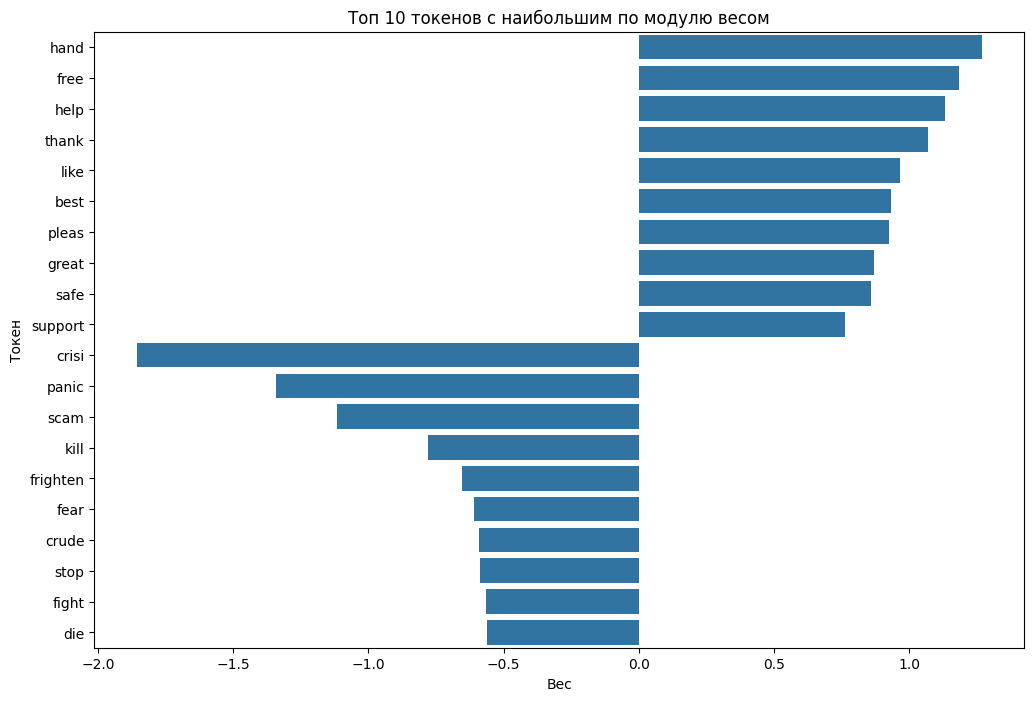

(0.9449807774455361,
 0.8472194538568866,
 ['hand',
  'free',
  'help',
  'thank',
  'like',
  'best',
  'pleas',
  'great',
  'safe',
  'support'],
 ['crisi',
  'panic',
  'scam',
  'kill',
  'frighten',
  'fear',
  'crude',
  'stop',
  'fight',
  'die'])

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

cv_min_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=0.00042)
cv_min_df.fit(X_train)
X_train_count_features_min_df = cv_min_df.transform(X_train)
X_test_count_features_min_df = cv_min_df.transform(X_test)

pipeline = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=1000))
pipeline.fit(X_train_count_features_min_df, y_train)


y_train_pred_scaled = pipeline.predict(X_train_count_features_min_df)
y_test_pred_scaled = pipeline.predict(X_test_count_features_min_df)
train_accuracy_scaled = accuracy_score(y_train, y_train_pred_scaled)
test_accuracy_scaled = accuracy_score(y_test, y_test_pred_scaled)


model_weights = pipeline.named_steps['logisticregression'].coef_[0]


top_positive_tokens = [token for token, weight in sorted(zip(cv_min_df.get_feature_names_out(), model_weights), key=lambda x: x[1], reverse=True)[:10]]
top_negative_tokens = [token for token, weight in sorted(zip(cv_min_df.get_feature_names_out(), model_weights), key=lambda x: x[1])[:10]]


import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=[weight for token, weight in sorted(zip(cv_min_df.get_feature_names_out(), model_weights), key=lambda x: x[1], reverse=True)[:10] + sorted(zip(cv_min_df.get_feature_names_out(), model_weights), key=lambda x: x[1])[:10]],
            y=[token for token, weight in sorted(zip(cv_min_df.get_feature_names_out(), model_weights), key=lambda x: x[1], reverse=True)[:10] + sorted(zip(cv_min_df.get_feature_names_out(), model_weights), key=lambda x: x[1])[:10]],
            orient='h')
ax.set_title('Топ 10 токенов с наибольшим по модулю весом')
ax.set_xlabel('Вес')
ax.set_ylabel('Токен')
plt.show()

train_accuracy_scaled, test_accuracy_scaled, top_positive_tokens, top_negative_tokens


На графике представлены 10 токенов с наибольшими положительными и отрицательными весами. Эти токены являются индикаторами положительной или отрицательной эмоциональной окраски текста:

Положительные токены (способствуют классификации твитта как положительного):
Например, слова вроде hand, free, help, thank и support связаны с поддержкой, благодарностью или безопасностью, что является позитивными атрибутами.
Отрицательные токены (способствуют классификации твитта как отрицательного):
Слова вроде crisi, panic, scam, frighten и kill указывают на кризисные ситуации, мошенничество или страх, что является негативными атрибутами.